Link to Colab: https://colab.research.google.com/drive/1Kf58YrcHPTyEdLSajA8qy0cTyd8dqUzn

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "cs231n-project"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pprint import pprint

from PIL import Image, ImageOps

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from image_dataset import *

dataset_path = f"/content/drive/My Drive/cs231n-project/dataset/Taskent"
taskent_dataset = PetroDataset(dataset_path)

__init__ PetroDataset with: /content/drive/My Drive/cs231n-project/dataset/Taskent


# Get one image and subimage and explore with DINO

In [ ]:
# Clear Cuda cache
if device == "cuda":
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()


# Load smallest dino model. ViT-S/8. Here ViT-S has ~22M parameters and
# works on 8x8 patches.
dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
dino_model.eval().to(device)



Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [ ]:
# Get one image and subimage

entry = taskent_dataset[0]
img, mask_human, mask_machine, img_filename, mask_human_filename, mask_machine_filename = entry

img_nparray = np.asarray(img)
mask_nparray = np.asarray(mask_machine)

print(img_nparray.shape)
print(mask_nparray.shape)

(3072, 3840, 3)
(3072, 3840, 3)


(np.float64(-0.5), np.float64(3839.5), np.float64(3071.5), np.float64(-0.5))

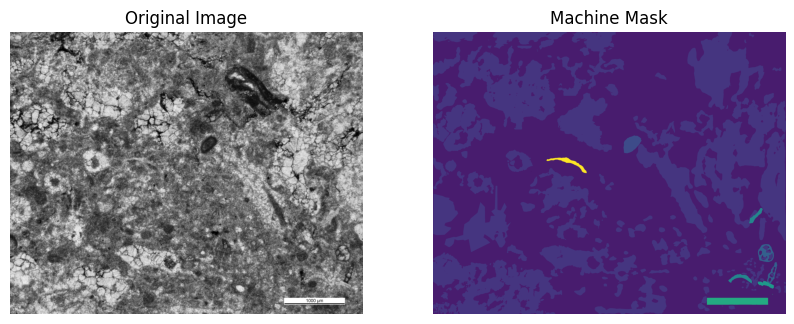

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes

ax1.imshow(img)
ax1.set_title('Original Image')
ax1.axis('off')

mask_machine_display = mask_machine.convert('L')
mask_machine_display = ImageOps.autocontrast(mask_machine_display)
ax2.imshow(mask_machine_display)
ax2.set_title('Machine Mask')
ax2.axis('off')

In [ ]:
sample_image = img

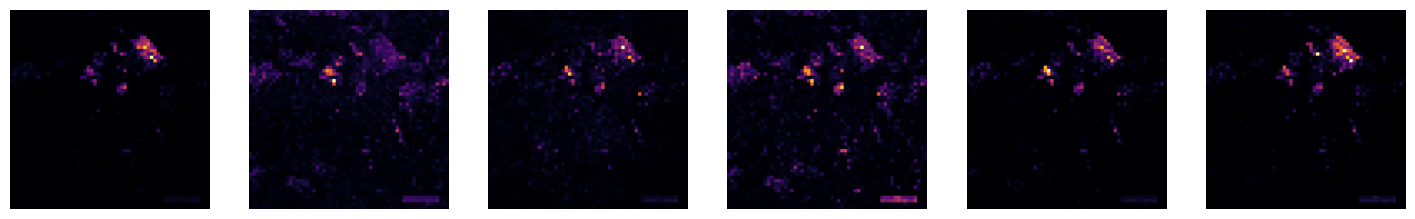

In [ ]:
# FROM HW3

# Preprocess
from torchvision import transforms as T
transform = T.Compose([
    T.Resize((480, 480)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img_tensor = transform(sample_image)
w, h = img_tensor.shape[1:]
img_tensor = img_tensor[None].to(device)

# Extract attention
with torch.no_grad():
    attn = dino_model.get_last_selfattention(img_tensor)[0, :, 0, 1:]
nh, tokens = attn.shape
w_feat, h_feat = w // 8, h // 8
attn = attn.reshape(nh, w_feat, h_feat)
attn = torch.nn.functional.interpolate(attn.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()

# Plot attention heads
fig, axes = plt.subplots(1, nh, figsize=(3 * nh, 3))
for i in range(nh):
    ax = axes[i] if nh > 1 else axes
    ax.imshow(attn[i], cmap='inferno')
    ax.axis('off')
plt.show()

In [ ]:
sub_image = img_nparray[0:480, 0:480]
sub_mask = mask_nparray[0:480, 0:480]

print(sub_image.shape)
print(sub_mask.shape)

(480, 480, 3)
(480, 480, 3)


(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

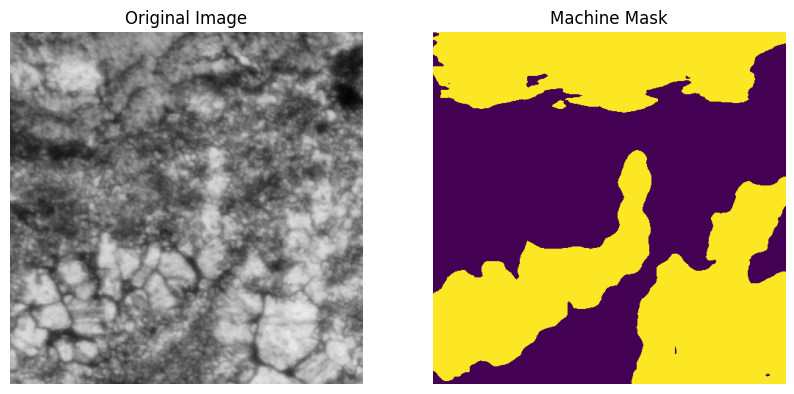

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes

ax1.imshow(sub_image)
ax1.set_title('Original Image')
ax1.axis('off')

mask_machine_display = Image.fromarray(sub_mask).convert('L')
mask_machine_display = ImageOps.autocontrast(mask_machine_display)
ax2.imshow(mask_machine_display)
ax2.set_title('Machine Mask')
ax2.axis('off')

In [ ]:
sample_image = Image.fromarray(sub_image)

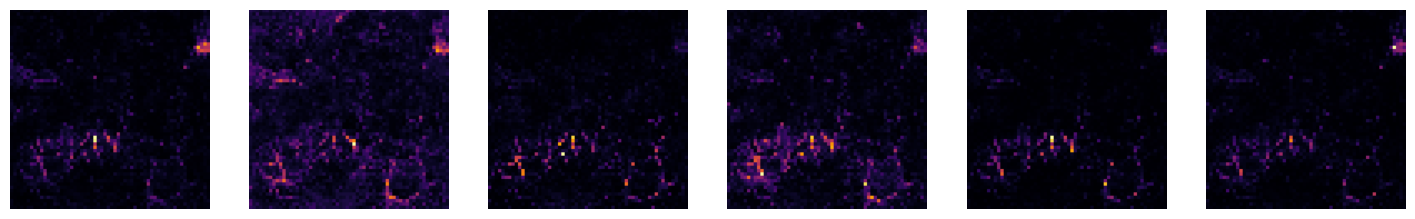

In [ ]:
# FROM HW3

# Preprocess
from torchvision import transforms as T
transform = T.Compose([
    T.Resize((480, 480)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img_tensor = transform(sample_image)
w, h = img_tensor.shape[1:]
img_tensor = img_tensor[None].to(device)

# Extract attention
with torch.no_grad():
    attn = dino_model.get_last_selfattention(img_tensor)[0, :, 0, 1:]
nh, tokens = attn.shape
w_feat, h_feat = w // 8, h // 8
attn = attn.reshape(nh, w_feat, h_feat)
attn = torch.nn.functional.interpolate(attn.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()

# Plot attention heads
fig, axes = plt.subplots(1, nh, figsize=(3 * nh, 3))
for i in range(nh):
    ax = axes[i] if nh > 1 else axes
    ax.imshow(attn[i], cmap='inferno')
    ax.axis('off')
plt.show()

In [ ]:
# Extract patch token features and discard [CLS] token.
with torch.no_grad():
    all_tokens = dino_model.get_intermediate_layers(img_tensor, n=1)[0]  # (1, 1+N, D)
    patch_tokens = all_tokens[:, 1:, :]  # (N, D)

print(img_tensor.shape)
print(all_tokens.shape)
print(patch_tokens.shape)

torch.Size([1, 3, 480, 480])
torch.Size([1, 3601, 384])
torch.Size([1, 3600, 384])


# PCA features

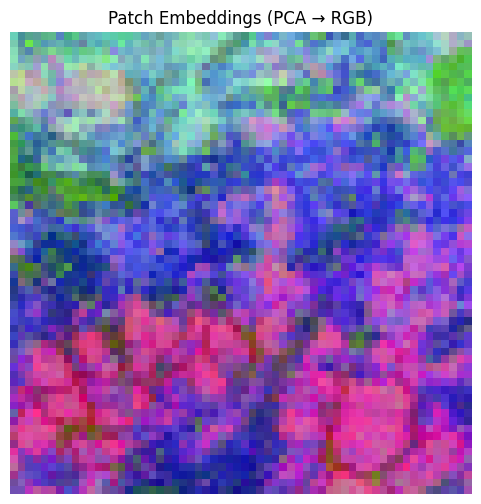

In [ ]:
from sklearn.decomposition import PCA

np.random.seed(231)

# PCA
pca = PCA(n_components=3)
patch_pca = pca.fit_transform(patch_tokens.cpu().numpy()[0])

# Normalize PCA components to [0, 1] for RGB display
patch_rgb = (patch_pca - patch_pca.min(0)) / (patch_pca.max(0) - patch_pca.min(0))

# Reshape to image grid (60x60, 3)
patch_rgb_img = patch_rgb.reshape(60, 60, 3)

# Show as image
plt.figure(figsize=(6, 6))
plt.imshow(patch_rgb_img)
plt.axis('off')
plt.title("Patch Embeddings (PCA → RGB)")
plt.show()


# Split input image into 480x480 sub images

In [ ]:
sub_image_size = 480

In [ ]:
def get_subimages(img, sub_image_size):

    image_nparray = np.asarray(img)
    H, W = image_nparray.shape[:2]
    num_subimages_h = H // sub_image_size
    num_subimages_w = W // sub_image_size

    subimages = [
        image_nparray[i*sub_image_size:(i+1)*sub_image_size, j*sub_image_size:(j+1)*sub_image_size]
        for i in range(num_subimages_h)
        for j in range(num_subimages_w)
    ]
    return subimages

In [ ]:
def get_one_channel(pixel):
    r,g,b = pixel
    return r

def get_submasks(img, sub_image_size):

    subimages = get_subimages(img,sub_image_size)
    submasks = [img[:,:,0] for img in subimages]

    return submasks

In [ ]:
entry = taskent_dataset[0]

img, mask_human, mask_machine, img_filename, mask_human_filename, mask_machine_filename = entry

image_nparray = np.asarray(entry[0])
mask_nparray = np.asarray(entry[2])

H, W = image_nparray.shape[:2]

num_subimages_h = H // sub_image_size
num_subimages_w = W // sub_image_size


subimages = get_subimages(entry[0], sub_image_size)
print(f"Image shape = {image_nparray.shape} splits into {len(subimages)}={num_subimages_h}x{num_subimages_w} patches of size {sub_image_size}x{sub_image_size}")
print(f"Shape of first subimage = {subimages[0].shape}")

submasks = get_submasks(entry[2], sub_image_size)
print(f"Mask shape = {mask_nparray.shape} splits into {len(submasks)}={num_subimages_h}x{num_subimages_w} patches of size {sub_image_size}x{sub_image_size}")
print(f"Shape of first submask = {submasks[0].shape}")


Image shape = (3072, 3840, 3) splits into 48=6x8 patches of size 480x480
Shape of first subimage = (480, 480, 3)
Mask shape = (3072, 3840, 3) splits into 48=6x8 patches of size 480x480
Shape of first submask = (480, 480)


# Decide which images are in Train vs Test

In [ ]:
all_dataset_indices = torch.arange(len(taskent_dataset))
test_dataset_indices = [all_dataset_indices[0]]
train_dataset_indices = all_dataset_indices[~torch.isin(all_dataset_indices, torch.tensor([test_dataset_indices]))]

train_dataset = torch.utils.data.Subset(taskent_dataset, train_dataset_indices)
test_dataset = torch.utils.data.Subset(taskent_dataset, test_dataset_indices)

print(f"all_dataset_indices = {all_dataset_indices}")
print(f"test_dataset_indices = {test_dataset_indices}")
print(f"train_dataset_indices = {train_dataset_indices}")

all_dataset_indices = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20])
test_dataset_indices = [tensor(0)]
train_dataset_indices = tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20])


# Split all images (train and test) into subimages

In [ ]:
X_train_images = [
    (img_filename, subimage_idx, subimage)
    for img, _, _, img_filename, _, _ in train_dataset
    for subimage_idx, subimage in enumerate(get_subimages(img,sub_image_size))
]

X_test_images = [
    (img_filename, subimage_idx, subimage)
    for img, _, _, img_filename, _, _ in test_dataset
    for subimage_idx, subimage in enumerate(get_subimages(img,sub_image_size))
]

Y_train_masks = [
    (img_filename, subimage_idx, subimage)
    for _, _, img, _, _, img_filename in train_dataset
    for subimage_idx, subimage in enumerate(get_submasks(img,sub_image_size))
]

Y_test_masks = [
    (img_filename, subimage_idx, subimage)
    for _, _, img, _, _, img_filename in test_dataset
    for subimage_idx, subimage in enumerate(get_submasks(img,sub_image_size))
]

print(f"Train X: {len(X_train_images)} images // Train Y: {len(Y_train_masks)} masks")
print(f"Test X: {len(X_test_images)} images // Test Y: {len(Y_test_masks)} masks")

Train X: 960 images // Train Y: 960 masks
Test X: 48 images // Test Y: 48 masks


In [ ]:
from pprint import pprint

pprint(f"X_train_images = {[(filename,idx) for filename, idx, _ in X_train_images]}")
pprint(f"Y_train_masks = {[(filename,idx) for filename, idx, _ in Y_train_masks]}")
pprint(f"X_test_images = {[(filename,idx) for filename, idx, _ in X_test_images]}")
pprint(f"Y_test_masks = {[(filename,idx) for filename, idx, _ in Y_test_masks]}")


("X_train_images = [('01_TK-0.75.jpg', 0), ('01_TK-0.75.jpg', 1), "
 "('01_TK-0.75.jpg', 2), ('01_TK-0.75.jpg', 3), ('01_TK-0.75.jpg', 4), "
 "('01_TK-0.75.jpg', 5), ('01_TK-0.75.jpg', 6), ('01_TK-0.75.jpg', 7), "
 "('01_TK-0.75.jpg', 8), ('01_TK-0.75.jpg', 9), ('01_TK-0.75.jpg', 10), "
 "('01_TK-0.75.jpg', 11), ('01_TK-0.75.jpg', 12), ('01_TK-0.75.jpg', 13), "
 "('01_TK-0.75.jpg', 14), ('01_TK-0.75.jpg', 15), ('01_TK-0.75.jpg', 16), "
 "('01_TK-0.75.jpg', 17), ('01_TK-0.75.jpg', 18), ('01_TK-0.75.jpg', 19), "
 "('01_TK-0.75.jpg', 20), ('01_TK-0.75.jpg', 21), ('01_TK-0.75.jpg', 22), "
 "('01_TK-0.75.jpg', 23), ('01_TK-0.75.jpg', 24), ('01_TK-0.75.jpg', 25), "
 "('01_TK-0.75.jpg', 26), ('01_TK-0.75.jpg', 27), ('01_TK-0.75.jpg', 28), "
 "('01_TK-0.75.jpg', 29), ('01_TK-0.75.jpg', 30), ('01_TK-0.75.jpg', 31), "
 "('01_TK-0.75.jpg', 32), ('01_TK-0.75.jpg', 33), ('01_TK-0.75.jpg', 34), "
 "('01_TK-0.75.jpg', 35), ('01_TK-0.75.jpg', 36), ('01_TK-0.75.jpg', 37), "
 "('01_TK-0.75.jpg', 38), ('

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

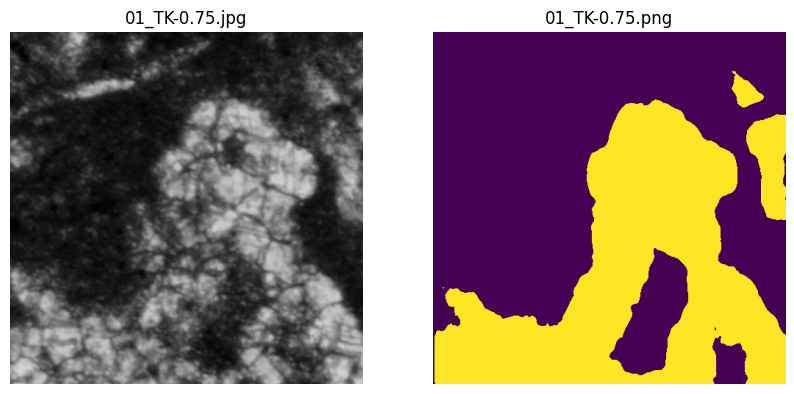

In [ ]:
# Visualize one Train/Test image pair

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes

ax1.imshow(X_train_images[0][2])
ax1.set_title(X_train_images[0][0])
ax1.axis('off')

mask_machine_display = Image.fromarray(Y_train_masks[0][2]).convert('L')
mask_machine_display = ImageOps.autocontrast(mask_machine_display)
ax2.imshow(mask_machine_display)
ax2.set_title(Y_train_masks[0][0])
ax2.axis('off')


# Pass all subimages to DINO

In [ ]:
from torchvision import transforms as T
transform = T.Compose([
#    T.Resize((480, 480)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

def get_dino_tokens(sample_image):
    img_tensor = transform(sample_image)
    # (3,480,480)
    w, h = img_tensor.shape[1:]
    img_tensor = img_tensor[None].to(device)
    # (1,3,480,480)

    with torch.no_grad():
        attn = dino_model.get_last_selfattention(img_tensor)[0, :, 0, 1:]
        # (6,3600)
        nh, tokens = attn.shape
        w_feat, h_feat = w // 8, h // 8
        attn = attn.reshape(nh, w_feat, h_feat)
        attn = torch.nn.functional.interpolate(attn.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()
        all_tokens = dino_model.get_intermediate_layers(img_tensor, n=1)[0]  # (1, 1+N, D)
    # pprint(all_tokens)
    return all_tokens.cpu()

def get_dino_tokens_batch(sample_images):
    # Transform batch of images
    img_tensors = torch.stack([transform(img) for img in sample_images])
    # (N,3,480,480)
    w, h = img_tensors.shape[2:]
    img_tensors = img_tensors.to(device)
    # (N,3,480,480)

    with torch.no_grad():
        attn = dino_model.get_last_selfattention(img_tensors)[:, :, 0, 1:]
        # (N,6,3600)
        nh, tokens = attn.shape[1:]
        w_feat, h_feat = w // 8, h // 8
        attn = attn.reshape(-1, nh, w_feat, h_feat)
        attn = torch.nn.functional.interpolate(attn, scale_factor=8, mode="nearest").cpu().numpy()
        all_tokens = dino_model.get_intermediate_layers(img_tensors, n=1)[0]  # (N, 1+pixels, D)
    # pprint(all_tokens)
    return all_tokens.cpu()

In [ ]:
# Try one subimage in DINO

subimage = X_train_images[0][2]
print(subimage.shape)

tokens = get_dino_tokens(subimage)
pprint(tokens.shape)

(480, 480, 3)
torch.Size([1, 3601, 384])


In [ ]:
# Try all subimages in DINO

pprint(len(X_train_images))

pprint(np.asarray(subimage).shape)
train_images = [subimage for _,_,subimage in X_train_images[0:8]]
print(np.asarray(train_images).shape)
# pprint(np.asarray(images).shape)

tokens = get_dino_tokens_batch(train_images)
# print(tokens.shape)

960
(480, 480, 3)
(8, 480, 480, 3)


In [ ]:
torch.save(tokens,"/content/drive/My Drive/cs231n-project/temp_tokens3.pt")

In [ ]:
print(torch.cuda.memory_allocated() / 1e6, "MB")
print(torch.cuda.memory_reserved() / 1e6, "MB")

19358.411264 MB
21007.171584 MB


In [ ]:
!nvidia-smi

Mon Jun  2 23:43:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             53W /  400W |   26485MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Test one submask values

submask = Y_train_masks[0][2]
pprint(submask.shape)
pprint(submask)

(480, 480, 3)
array([[[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       ...,

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [10, 10, 10],
        ...,
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]]], dtype=uint8)


In [ ]:
mask_machine = taskent_dataset[0][2]
mask_machine_nparray = np.asarray(mask_machine)
pprint(mask_machine_nparray.shape)
pprint(mask_machine_nparray)

(3072, 3840, 3)
array([[[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)


In [ ]:
# X_train_dino_features = [
#     (img_filename, sub_image_idx, get_dino_tokens(sub_image))
#     for img_filename, sub_image_idx, sub_image in X_train_subimages[:2]
# ]

# X_test_dino_features = [
#     (img_filename, sub_image_idx, get_dino_features(sub_image))
#     for img_filename, sub_image_idx, sub_image in X_test_subimages
# ]

# Y_train_dino_features = [
#     (img_filename, sub_image_idx, get_dino_features(sub_image))
#     for img_filename, sub_image_idx, sub_image in Y_train_submasks
# ]

# Y_test_dino_features = [
#     (img_filename, sub_image_idx, get_dino_features(sub_image))
#     for img_filename, sub_image_idx, sub_image in Y_test_submasks
# ]
